### Privacy preserving logistic regression
#### Unweighted, discrete

There are three main methods to compute a differentially private, unweighted, discrete logistic regression.
1. reframe discrete predictors as a table of values, add laplace noise
2. randomized response
3. perturbed optimization

In this notebook, we will explore each method and evaluate their privacy/accuracy tradeoff performance.

In [34]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests, zipfile, io
import sklearn
import random
from typing import Union
import statsmodels.api as sm

## Logistic Regression as Post-Processing

In [35]:
if 'pa' not in locals():
    r = requests.get('https://www2.census.gov/programs-surveys/acs/data/pums/2017/5-Year/csv_pla.zip')
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extract('psam_p22.csv')
    keepcols = ['PUMA','RACWHT','PINCP','AGEP','SCHL','MIGPUMA','MIGSP']
    pa = pd.read_csv("psam_p42.csv", usecols=keepcols)

In [36]:
#getting data
#new_pa = pa.query('PUMA==1300 and AGEP>=18 and AGEP<=65').filter(items=['PUMA','RAC1P','PINCP','AGEP','SCHL','MIGPUMA','MIGSP'])
pa.query('PUMA==1300 and AGEP>=18 and AGEP<=65', inplace=True)
pa.head()
#TODO clean data

,PUMA,AGEP,SCHL,MIGPUMA,MIGSP,PINCP,RACWHT,MIGRATED,ADULT
436,1300,56,22.0,NaN,NaN,65000.0,1,0,1
437,1300,54,20.0,NaN,NaN,15000.0,1,0,1
590,1300,57,16.0,NaN,NaN,62000.0,1,0,1
591,1300,58,16.0,NaN,NaN,44500.0,1,0,1
652,1300,46,15.0,NaN,NaN,20000.0,1,0,1


In [37]:
def migrecode(migpuma):
    if pd.isnull(migpuma):
        return 0
    else:
        return 1
    
def agerecode(age):
    if age < 18:
        return 0
    else:
        return 1
    

pa['MIGRATED']=pa.MIGPUMA.apply(migrecode)
pa['ADULT']=pa.AGEP.apply(agerecode)
print(pa.head())
print(pa.MIGRATED.value_counts())

     PUMA  AGEP  SCHL  MIGPUMA  MIGSP    PINCP  RACWHT  MIGRATED  ADULT
436  1300    56  22.0      NaN    NaN  65000.0       1         0      1
437  1300    54  20.0      NaN    NaN  15000.0       1         0      1
590  1300    57  16.0      NaN    NaN  62000.0       1         0      1
591  1300    58  16.0      NaN    NaN  44500.0       1         0      1
652  1300    46  15.0      NaN    NaN  20000.0       1         0      1
0    7926
1     897
Name: MIGRATED, dtype: int64


In [38]:
#feature selection 
#TODO: change Y value to rent or mortage
X = pa[['RACWHT','ADULT','SCHL']]
y = pa.MIGRATED

logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.325422
         Iterations 6
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.010     
Dependent Variable: MIGRATED         AIC:              5748.4018 
Date:               2019-08-14 18:05 BIC:              5769.6572 
No. Observations:   8823             Log-Likelihood:   -2871.2   
Df Model:           2                LL-Null:          -2900.4   
Df Residuals:       8820             LLR p-value:      2.1461e-13
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     6.0000                                       
-------------------------------------------------------------------
           Coef.    Std.Err.      z      P>|z|     [0.025    0.975]
-------------------------------------------------------------------
RACWHT    -1.1194     0.1387   -8.0717   0.0000   -1.3912   -0.8476
ADULT     -0.8946     0.2262   -3.9548   0.0001   -1.3380 

In [63]:
tab=pd.crosstab(pa.MIGRATED, [pa.RACWHT, pa.ADULT, pa.SCHL]).unstack()
print(tab)

RACWHT  ADULT  SCHL  MIGRATED
0       1      1.0   0             12
                     1              1
               7.0   0              1
                     1              0
               9.0   0              1
                     1              1
               11.0  0              2
                     1              1
               12.0  0              4
                     1              3
               13.0  0             10
                     1              9
               14.0  0             21
                     1              3
               15.0  0             13
                     1              2
               16.0  0             51
                     1             18
               17.0  0             51
                     1             18
               18.0  0             17
                     1              9
               19.0  0             21
                     1              8
               20.0  0              4
                    

## Laplace Noise

In [13]:
def laplace_mech(mu: Union[float, np.ndarray], epsilon: int, sensitivity: float = 1.0):
    """
    Implementation of the Laplace Mechanism

    Args:
      mu (float or numpy array): the true answer
      epsilon (int): the privacy budget
      sensitivity (float): the global sensitivity of the query
    """
    eps = epsilon/float(sensitivity)
    scale = 1/eps
    np_shape = np.shape(mu)
    shape = None if np_shape == () else np_shape
    z = np.random.laplace(0.0, scale=scale, size=shape)
    return mu + z

In [14]:
def avg_l1_laplace(epsilon, mu, n=1000):
    """Takes the average error of the laplace mechanism on an array over n samples.
  　
    Args:
      epsilon (int): the privacy budget
      mu (float or numpy array): the true answer
      n (int): number of samples
    """
    total = 0
    for i in range(n):
        noisy_arr = laplace_mech(mu, epsilon, sensitivity=1.0)
        accuracy = 1 - (np.linalg.norm(noisy_arr-mu, 1)/(2*noisy_arr.shape[1]))
        total += accuracy
    return total/n


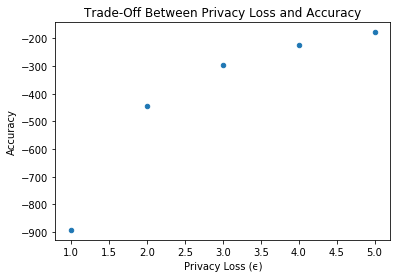

In [15]:
orig_arr = pd.DataFrame(new_pa.fillna(0))
accuracy_df = pd.DataFrame()
eps_range = np.arange(1,6.0,1)
accuracy_df['Privacy Loss (ϵ)'] = eps_range
accuracy_df['Accuracy'] = [avg_l1_laplace(x, orig_arr) for x in eps_range]
accuracy_df.plot.scatter('Privacy Loss (ϵ)', 'Accuracy')
plt.title('Trade-Off Between Privacy Loss and Accuracy')
plt.style.use('seaborn-paper')
plt.savefig('out/fig.png',facecolor='w', edgecolor='w',
        orientation='portrait', ransparent=False, bbox_inches=None, pad_inches=0.1)
plt.show()

In [16]:
noisy_microdata = laplace_mech(orig_arr,3)
X = noisy_microdata[['RAC1P','AGEP','SCHL']]
y = noisy_microdata['PINCP'].apply(labeler)
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.683032
         Iterations 5
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.015     
Dependent Variable: PINCP            AIC:              12058.7793
Date:               2019-08-13 18:29 BIC:              12080.0346
No. Observations:   8823             Log-Likelihood:   -6026.4   
Df Model:           2                LL-Null:          -6115.5   
Df Residuals:       8820             LLR p-value:      1.9303e-39
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     5.0000                                       
-------------------------------------------------------------------
          Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
-------------------------------------------------------------------
RAC1P    -0.2488     0.0248   -10.0326   0.0000   -0.2975   -0.2002
AGEP      0.0081     0.0014     5.9446   0.0000    0.0054 

## Random Response 

In [18]:
print(noisy_microdata)

               PUMA     RAC1P          PINCP       AGEP       SCHL
436     1300.247781  0.852751   64999.980471  55.882872  21.963363
437     1299.438755  1.147954   14999.979268  53.537880  19.375723
590     1298.896883  0.835699   62000.140623  56.683960  14.908162
591     1300.081673  1.082736   44499.873305  58.207240  16.093071
652     1300.541077  1.672024   19999.471167  45.607088  14.876569
696     1300.006355  0.796937   12699.135954  57.862641  15.194693
1141    1298.706597  1.105754   59999.280899  44.179970  16.028446
1142    1299.330959  1.099140   44000.081136  41.605838  18.027975
1337    1299.925226  1.174527   34999.875968  46.040513  15.515920
1372    1300.064246  1.037863   22999.745139  41.794241  16.889729
1373    1299.271035  1.113471   13999.946911  19.552497  16.196711
1374    1300.381573  0.773457   29999.130792  42.654994  13.264253
1513    1300.039252  1.527336   35004.283673  64.954033  21.678232
1514    1300.299712  0.969656   21999.974062  58.817677  15.85